## **CAPTCHA Bypass**

##### **Team 99**

Nicholas Leung

Coden Mercurius

Pranavbhai Patel

Ravi Singh

##### **Description**

CAPTCHA, or Completely Automated Public Turing Test to Tell Computers and Humans Apart, is a challenge-response test that determines whether a user is authentic (human) or inauthentic (machine). They require users to authenticate themselves by retyping a character sequence prior to completing a request. This notebook implements a CAPTCHA bypass using deep learning. The team aims to investigate weaknesses and vulnerabilities of the CAPTCHA system.

In [ ]:
%%shell
jupyter nbconvert --to html /content/captcha.ipynb

[NbConvertApp] Converting notebook /content/captcha.ipynb to html
[NbConvertApp] Writing 907664 bytes to /content/captcha.html


In [2]:
# Imports
import torch
import torch.nn as nn
import os
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

## **Part 1. Data Processing**

The dataset for this model is generated using the following library: https://github.com/lepture/captcha and automated by the script `dataset_generator.py`.

The character space began as purely numeric (0-9) but has since expanded to become alphanumeric (0-9, A-Z). Alphabetical characters are capitalized. Characters are uniformly distributed in terms of occurrence in the dataset.

The generated dataset `alphanumeric_dataset.zip` is availiable on the private team Google Drive because it is too large for the Github repository. Upload `alphanumeric_dataset.zip` into the Colab Files and unzip.

In [3]:
# Unzip dataset
!unzip  -qq /content/dataset.zip -d /content/

In [4]:
class CaptchaDataset(Dataset):
  """ Captcha Dataset """

  def __init__(self, directory):
    self.directory = directory
    self.captchas = os.listdir(directory)
    self.captchas.remove("metadata.txt")

    self.transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    self.character_set = open(directory + "/metadata.txt", "r").readline().split(',')
    self.characters_to_identifier = {}

    for i in range(len(self.character_set)):
      self.characters_to_identifier.update({ self.character_set[i]: i })

  def __len__(self):
    # Assumes each file in the dataset directory represents a data sample
    return len(self.captchas)

  def __getitem__(self, index):
    sample_name = self.captchas[index]
    sample_captcha_values = list(sample_name[0:-4]) # Slice s.t. remove png file extension

    # Read the image and represent it as a tensor
    image = io.imread(self.directory + '/' + sample_name)
    image = self.transform(image)

    # Represent each character as an integer identifier
    label = []
    for char in sample_captcha_values:
      label.append(self.characters_to_identifier.get(char))

    return (image, torch.tensor(label))

In [5]:
dataset_path = "/content/dataset"

# Instantiate dataset
dataset = CaptchaDataset(dataset_path)

In [6]:
def visualize_character_frequency(dataloader, title):
  character_frequency = {} # Contains frequency information
  character_set = dataset.character_set

  # Populate character_frequency
  for _, labels in dataloader:
    for label in labels:
      for char_identifier in label:
        char = character_set[char_identifier.item()]
        current_value = character_frequency.get(char, None)

        if current_value is None: 
          character_frequency.update({ char : 0 })
        else:
          character_frequency.update({ char : current_value + 1 })

  x_values = range(len(character_set))
  y_values = []

  for char in character_set:
    count = character_frequency.get(char)
    y_values.append(count)

  plt.title(title)
  plt.plot(x_values, y_values)
  plt.xlabel("Characters")
  plt.ylabel("Count")
  plt.xticks(x_values, character_set)
  plt.show()

In [7]:
def get_data_loaders(dataset, batch_size, total_size=None):

  if total_size is None:
    total_size = len(dataset)

  training_ratio = 0.7
  validation_ratio = 0.15
  # test_ratio implied

  train_length = int(total_size * training_ratio)
  validation_length = int((total_size - train_length) * (validation_ratio / ( 1 - training_ratio )))
  test_length = total_size - train_length - validation_length
  fill = len(dataset) - total_size
  
  train_set, valid_set, test_set, fill_set = torch.utils.data.random_split(dataset, [train_length, validation_length, test_length, fill], torch.Generator().manual_seed(10))

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, drop_last=True, shuffle=True)

  return train_loader, valid_loader, test_loader

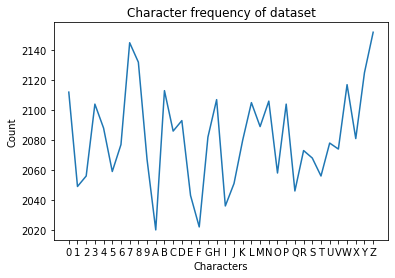

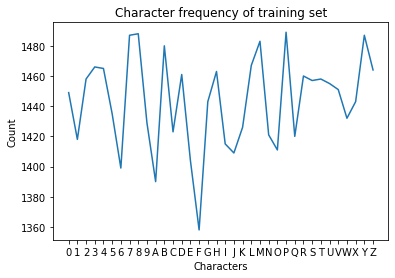

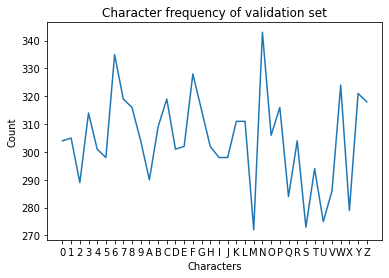

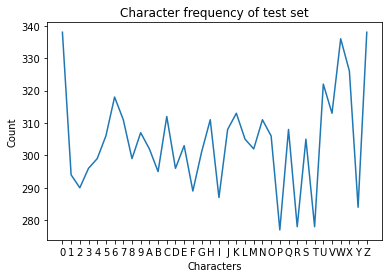

In [8]:
# Dataset visualization
train, valid, test = get_data_loaders(dataset, 100)

visualize_character_frequency(torch.utils.data.DataLoader(dataset, num_workers=1), title="Character frequency of dataset")
visualize_character_frequency(train, title="Character frequency of training set")
visualize_character_frequency(valid, title="Character frequency of validation set")
visualize_character_frequency(test, title="Character frequency of test set")

## **Part 2. Character Segmentation**

Character segmentation must occur prior to character classification. This entails using `OpenCV.findContours()` to perform blob detection on a CAPTCHA image input. This will extract each individual character (5 total) for input to the model. This module has two implementations, one using deep-learning and another that does not. The deep learning implementation uses a model to predict good "slicing" points for overlapping characters.

The models used in the module are supplied as trained models `2Char.pth` and `3Char.pth` which can be found in the project GitHub repo. Make sure you upload these files to your local session before running the below cells.

In [9]:
import random
import cv2
import torchvision as tv

In [10]:
class Chars2(nn.Module):
    def __init__(self):
        super(Chars2, self).__init__()
        self.conv1 = nn.Conv2d(1,7,5,1,4)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(7, 14, 5,1, 4)
        self.pool2 = nn.MaxPool2d(2,2)
        

        self.conv3 = nn.Conv2d(14, 28, 5,1, 4)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(28, 56, 5,1, 4)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(56, 70, 5,1, 4)
        self.pool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(70, 80, 5,1, 4)
        self.pool6 = nn.MaxPool2d(2,2)
        


        self.fc1 = nn.Linear(2000, 100)
        self.fc2 = nn.Linear(100, 1)

        self.lrelu=torch.nn.LeakyReLU(-0.001)

    def forward(self, img):
        x = self.pool1(self.lrelu(self.conv1(img)))
        x = self.pool2(self.lrelu(self.conv2(x)))
        x = self.pool3(self.lrelu(self.conv3(x)))
        x = self.pool4(self.lrelu(self.conv4(x)))
        #print(x.shape)
        x = self.pool5(self.lrelu(self.conv5(x)))
        #print(x.shape)
        x = self.pool6(self.lrelu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 2000)
        x = self.fc2(self.lrelu(self.fc1(x)))
        return x

In [11]:
class Chars3(nn.Module):
    def __init__(self):
        super(Chars3, self).__init__()
        self.conv1 = nn.Conv2d(1,7,5,1,4)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(7, 14, 5,1, 4)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(14, 28, 5,1, 4)
        self.pool3 = nn.MaxPool2d(2,2)

        self.conv4 = nn.Conv2d(28, 56, 5,1, 4)
        self.pool4 = nn.MaxPool2d(2,2)

        self.conv5 = nn.Conv2d(56, 70, 5,1, 4)
        self.pool5 = nn.MaxPool2d(2,2)

        self.conv6 = nn.Conv2d(70, 80, 5,1, 4)
        self.pool6 = nn.MaxPool2d(2,2)
        


        self.fc1 = nn.Linear(2000, 130)
        self.fc2 = nn.Linear(130, 2)

        self.lrelu=torch.nn.LeakyReLU(-0.001)

    def forward(self, img):
        x = self.pool1(self.lrelu(self.conv1(img)))
        x = self.pool2(self.lrelu(self.conv2(x)))
        x = self.pool3(self.lrelu(self.conv3(x)))
        x = self.pool4(self.lrelu(self.conv4(x)))
        #print(x.shape)
        x = self.pool5(self.lrelu(self.conv5(x)))
        #print(x.shape)
        x = self.pool6(self.lrelu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 2000)
        x = self.fc2(self.lrelu(self.fc1(x)))
        return x

In [13]:
"""Load Previously saved model weights"""
modelChars2=Chars2()
modelChars2.load_state_dict(torch.load('2Char.pth'))
modelChars3=Chars3()
modelChars3.load_state_dict(torch.load('3Char.pth'))

<All keys matched successfully>

In [14]:
def processimage(image, thresh):
      #Format image type/ dimensions
      image=image.permute(1,2,0)
      image=image.numpy()
      imageorig=image
      
      #Modify image so contours/ borders can be easily found
      #Greyscale
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      #Binary Threshold
      NA, image = cv2.threshold(image, thresh, 1, cv2.THRESH_BINARY)
      #Erosion
      #kernel = np.ones((2,2),np.uint8)
      #image = cv2.dilate(image,kernel,iterations = 1)
      #Vertical Blur and Resharpen
      morpher = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, morpher)
      #Binary Threshold  
      thresh, image = cv2.threshold(image,thresh, 1, cv2.THRESH_BINARY)
      #Expand Border
      image=cv2.copyMakeBorder(image, 5, 5, 5, 5,cv2.BORDER_CONSTANT,value=1)
      image = image.astype(np.uint8)

      return imageorig,image

In [15]:
def segmentimage(image,narrow):
    #Return list of borderlines in image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #imagecont=cv2.drawContours(image, contours, -1, (0, 0.5, 0), 1)

    #Creates boxes for every large object
    boxes=[]
    for contour in contours:
        [x,y,w,h]=cv2.boundingRect(contour)
        if(w>8 and w<120 and h>22):
          boxes.append([x,y,w,h])
    boxes.sort(key=lambda x: x[0])

    #Eliminates boxes that are contained whithin other boxes (subparts of a letter)
    i=1
    while (i<len(boxes)):
      box=boxes[i]
      boxprev=boxes[i-1]
      if (box[0]>boxprev[0] and box[1]>boxprev[1] and (box[0]+box[2])<(boxprev[0]+boxprev[2]) and (box[1]+box[3])<(boxprev[1]+boxprev[3])):
        boxes.pop(i)
        i-=1
      i+=1

    #If boxes are too wide they may contain multiple boxes 
    #They are split vertically into 2 or 3 subboxes (even width splits)
    i=0
    """while (i<len(boxes)):
      box=boxes[i]
      if (box[2]>box[3]*(0.95-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int((2*w)/3),y,int(w/3),h])
        boxes.insert(i,[x+int((w)/3),y,int(w/3),h])
        boxes.insert(i,[x,y,int(w/3),h])
      elif (box[2]>box[3]*(0.6-narrow)):
        x,y,w,h=boxes.pop(i)
        boxes.insert(i,[x+int(w/2),y,int(w/2),h])
        boxes.insert(i,[x,y,int(w/2),h])
      if (i>=len(boxes)-1):
        break
      i+=1"""
    
    return boxes


    


In [16]:
#Resizes an image according to the given dimensions. No distortion applied
def resizeimage(image,dheight,dwidth):
  height=image.shape[0]
  width=image.shape[1]
  if (width>height):
    topbuffer=int ((width-height)/2)
    topbufferoverwidth=float(topbuffer)/width
    sidebufferoverwidth=0
    image=cv2.copyMakeBorder(image,topbuffer,topbuffer, 0, 0,cv2.BORDER_CONSTANT,value=1)
  else:
    sidebuffer=int ((height-width)/2)
    sidebufferoverwidth=float(sidebuffer)/height
    topbufferoverwidth=0
    image=cv2.copyMakeBorder(image,0,0, int ((height-width)/2), int ((height-width)/2),cv2.BORDER_CONSTANT,value=1)
  image = cv2.resize(image, dsize=(dwidth, dheight), interpolation=cv2.INTER_CUBIC)
  return image,topbufferoverwidth,sidebufferoverwidth


In [17]:
def getcharacterimages(images,dheight=80,dwidth=80, showsegments=False, deeplearning=False ):
  characters=[]
  for i in range (0,len(images)):
    imageraw = images[i]
 
    """CAPTCHA image pre-processed, custom function called"""
    # Rectangle Borders of each character obtained, custom function called
    # Binary Threshold is adaptably adjusted until image is seen
    thresh, narrow = 0.6,0
    for x in range(0,5):  
      imageorig, image=processimage(imageraw,thresh)
      imageboxes = np.copy(image)
      boxes=segmentimage(image,narrow)
      if (len(boxes)<=1):
        thresh+=x*0.1
      else:
        break
    
    """Estimating Characters per box"""
    # We estimate this number by the ratio of height to width
    # The ratio is adaptably adjusted until we meet 5 characters
    narrow=0 
    for x in range (0,200):
      numchars=[]
      narrow+=x*0.005
      for i in range(0,len(boxes)):
        box=boxes[i]
        if (box[2]>box[3]*(0.95-narrow)):
          numchars.append(3)
        elif (box[2]>box[3]*(0.6-narrow)):
          numchars.append(2)
        else:
          numchars.append(1)
      # Only break if 5 characters are estimated
      sum=0
      for j in range(0,len(numchars)):
        sum+=numchars[j]
      if (sum>=5):
        break
    
    #Add 0 estimates, if there are still less than 5 numchar estimates
    while (len(numchars)<5):
      numchars.append(0)

    """If deeplearning off, cut boxes"""
    if (deeplearning==False):
      boxnum=0
      for i in range(0,len(boxes)):
          #boxnum tracks boxes, i tracks numchars prediction
          box=boxes[boxnum]
          if (numchars[i]==3):
            x,y,w,h=boxes.pop(boxnum)
            boxes.insert(boxnum,[x+int((2*w)/3),y,int(w/3),h])
            boxes.insert(boxnum,[x+int((w)/3),y,int(w/3),h])
            boxes.insert(boxnum,[x,y,int(w/3),h])
            boxnum+=3
          elif (numchars[i]==2):
            x,y,w,h=boxes.pop(boxnum)
            boxes.insert(boxnum,[x+int(w/2),y,int(w/2),h])
            boxes.insert(boxnum,[x,y,int(w/2),h])
            boxnum+=2
          else:
            boxnum+=1


    #Filter bad segmentation cases
    #Update: Feature no longer possible
    #if filterBadSegmentation and len(boxes) < 5:
      #continue

    """Cutting out Box Images from CAPTCHA"""
    charactersset=[]
    for i in range(0,5):
      # If insufficient letters obtainable, add an empty image
      if (i<len(boxes)):
        box=boxes[i]
      else:
        box=[0,0,1,1]

      [x,y,w,h]=box
      char=image[y:y+h,x:x+w]
      height=char.shape[0]
      width=char.shape[1]
      # cv2.copyMakeBorder(soruce, top, bottom, left, right, borderType, value)

      #Resizing Image
      char,topbufferoverwidth,sidebufferoverwidth=resizeimage(char,80,80)


      """If deeplearning = True, use models to split images"""
      if (deeplearning==False):
        charactersset.append(char)
      else:
        if (numchars[i]==2):
          input=torch.Tensor(char).unsqueeze(0).unsqueeze(0)
          #Splitting Estimate from Model
          horsplit=round(modelChars2(input).item())
          if (topbufferoverwidth!=0):
            #Cut off excess top, split according to model prediction, resize
            char1=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),0:horsplit]
            char2=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit:]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
          else:
            #Cut off excess sides, split according to model prediction, resize
            char1=char[:,round(sidebufferoverwidth*80):horsplit]
            char2=char[:,horsplit:round(80-sidebufferoverwidth*80)]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
        elif (numchars[i]==3):
          input=torch.Tensor(char).unsqueeze(0).unsqueeze(0)
          #Splitting Estimate from Model
          output=modelChars3(input).squeeze()
          horsplit=round(output[0].item()),round(output[1].item())
          if (topbufferoverwidth!=0):
            #Cut off excess top, split according to model prediction, resize
            char1=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),0:horsplit[0]]
            char2=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit[0]:horsplit[1]]
            char3=char[round(topbufferoverwidth*80):round(80-80*topbufferoverwidth),horsplit[1]:]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            char3=resizeimage(char3,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
            charactersset.append(char3)
          else:
            #Cut off excess sides, split according to model prediction, resize
            char1=char[:,round(sidebufferoverwidth*80):horsplit[0]]
            char2=char[:,horsplit[0]:horsplit[1]]
            char3=char[:,horsplit[1]:round(80-sidebufferoverwidth*80)]
            char1=resizeimage(char1,80,80)[0]
            char2=resizeimage(char2,80,80)[0]
            char3=resizeimage(char3,80,80)[0]
            charactersset.append(char1)
            charactersset.append(char2)
            charactersset.append(char3)
        else:
          charactersset.append(char)


      #Draw Boxes
      cv2.rectangle(imageboxes,(x,y),(x+w,y+h),0,1)

    """Resizes Images accoring to the given dimensions"""
    for i in range(0,5):
      nchar=resizeimage(charactersset[i],dheight,dwidth)[0]
      charactersset[i]=torch.Tensor(nchar)

    charactersset=torch.stack(charactersset[0:5])
    characters.append(charactersset)
    
    
    
    """ShowSegments = True: Visualization of the entire process"""
    if (showsegments==True):
      plt.imshow(imageorig)
      plt.show()
      plt.imshow(imageboxes, cmap='gray', vmin = 0, vmax = 1)
      plt.show()

      print("      ",end="")
      for j in range(0,len(numchars)):
        print(numchars[j],end="        ")
      print("",end="")

      for i in range(0,len(charactersset)):
        plt.subplot(1,5,i+1)
        plt.imshow(charactersset[i], cmap='gray', vmin = 0, vmax = 1)
      plt.show()

  return torch.stack(characters)
  

In [18]:
"""
How To Use - getcharacterimages(images, showsegments=False)

Input = tensor(batchsize,numchannels,height,width) (see below)
Output = tensor(batchsize, numcharacters = 5, height = 80, width = 80 )

Set `showsegments` to `True`to visualize segmentation
"""
train, valid, test = get_data_loaders(dataset, 100)

for images, labels in valid:
  characters = getcharacterimages(images, showsegments=False, deeplearning=True)

## **Part 3. Base Model**

The base model is a non-deep learning method. The base model leverages the previous character segmentation module (the non-deep learning implementation) and an SVM architecture is used for character classification.

The base model is to serve as a baseline of comparison for the primary model.

In [19]:
from sklearn import svm
import numpy as np

In [20]:
class BaseModel:

  def __init__(self):
    self.classifier = svm.SVC()

  def fit_classifier(self, dataloader):

    # Preprocessing to make our PyTorch data in acceptable format

    input_acc = []
    labels_acc = []

    for images, labels in dataloader:

      segmented_captchas = getcharacterimages(images, dheight=28, dwidth=28)

      # Iterate over each captcha
      for i in range(len(segmented_captchas)):
        captcha = segmented_captchas[i]
        
        # Iterate over each character
        for j in range(len(captcha)):
          input_acc.append(captcha[j].detach().numpy().reshape(-1))
          labels_acc.append(labels[i][j].detach().numpy())
    
    input_acc = np.array(input_acc)
    labels_acc = np.array(labels_acc)

    # Train character classification

    self.classifier.fit(input_acc, labels_acc)

  def predict(self, images):
    segmented_captchas = getcharacterimages(images, dheight=28, dwidth=28)

    output = []
    for captcha in segmented_captchas:

      out_captcha = []

      for character in captcha:
        numpy_char = character.detach().numpy().reshape((1, -1)) # Reshape to acceptable input for SVM predict()
        out_char = self.classifier.predict(numpy_char)
        out_captcha.append(out_char.item())
      
      output.append(out_captcha)

    return torch.tensor(output)


In [21]:
base_model = BaseModel()
train_small, valid_small, test_small = get_data_loaders(dataset, 100, 3000)

base_model.fit_classifier(train_small)

In [22]:
def evaluate_base_model(model, dataloader):

  total_character_guesses = 0
  total_captcha_guesses = 0

  incorrect_character_guesses = 0
  incorrect_captcha_guesses = 0

  failed_guess_frequency = {}

  for images, labels in dataloader:
    out = model.predict(images)

    # Iterate through each sample captcha in batch
    for i in range(len(labels)):
      bad_guess = False

      # Iterate through each character of captcha
      for j in range(len(labels[i])):

        total_character_guesses = total_character_guesses + 1
        guess = out[i][j]
        expected = labels[i][j]

        if (guess != expected):
          incorrect_character_guesses = incorrect_character_guesses + 1

          # Track per character bad guesses
          current_failed_guess_count = failed_guess_frequency.get(dataset.character_set[guess], 0)
          failed_guess_frequency.update({ dataset.character_set[guess]: current_failed_guess_count + 1 })

          bad_guess = True
      
      if bad_guess:
        incorrect_captcha_guesses = incorrect_captcha_guesses + 1
      
      total_captcha_guesses = total_captcha_guesses + 1

  # Overall accuracy information

  character_guess_accuracy = (total_character_guesses - incorrect_character_guesses) / total_character_guesses
  captcha_guess_accuracy = (total_captcha_guesses - incorrect_captcha_guesses) / total_captcha_guesses
  
  print(f"Character Accuracy: {character_guess_accuracy}")
  print(f"Captcha Accuracy: {captcha_guess_accuracy}")

  # Plot incorrect character guess frequency

  bad_guess_character_set = failed_guess_frequency.keys()

  x_values = range(len(bad_guess_character_set))
  y_values = []

  for char in bad_guess_character_set:
    count = failed_guess_frequency.get(char)
    y_values.append(count)

  plt.title("Bad guess character frequency")
  plt.plot(x_values, y_values)
  plt.xlabel("Characters")
  plt.ylabel("Count")
  plt.xticks(x_values, bad_guess_character_set)
  plt.show()



In [23]:
def get_confusion_matrix_base_model(model, dataloader):

  matrix = np.zeros((len(dataset.character_set), len(dataset.character_set)))
  character_frequency = np.zeros(len(dataset.character_set))

  for images, labels in dataloader:
    out = model.predict(images)

    # Iterate through each sample captcha in batch
    for i in range(len(labels)):
      # Iterate through each character of captcha
      for j in range(len(labels[i])):
        guess = int(out[i][j])
        expected = int(labels[i][j])

        character_frequency[guess] = character_frequency[guess] + 1
        matrix[guess][expected] = matrix[guess][expected] + 1
  
  # Normalize to percentages
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      matrix[i][j] = (matrix[i][j] / character_frequency[i] * 100).round()
  
  plt.subplots(figsize=(15,15))
  labels = dataset.character_set
  sns.heatmap(matrix, annot=True, cmap=sns.color_palette("light:b", as_cmap=True), xticklabels=labels, yticklabels=labels)

Character Accuracy: 0.8350909090909091
Captcha Accuracy: 0.514090909090909


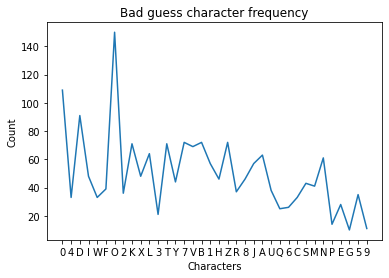

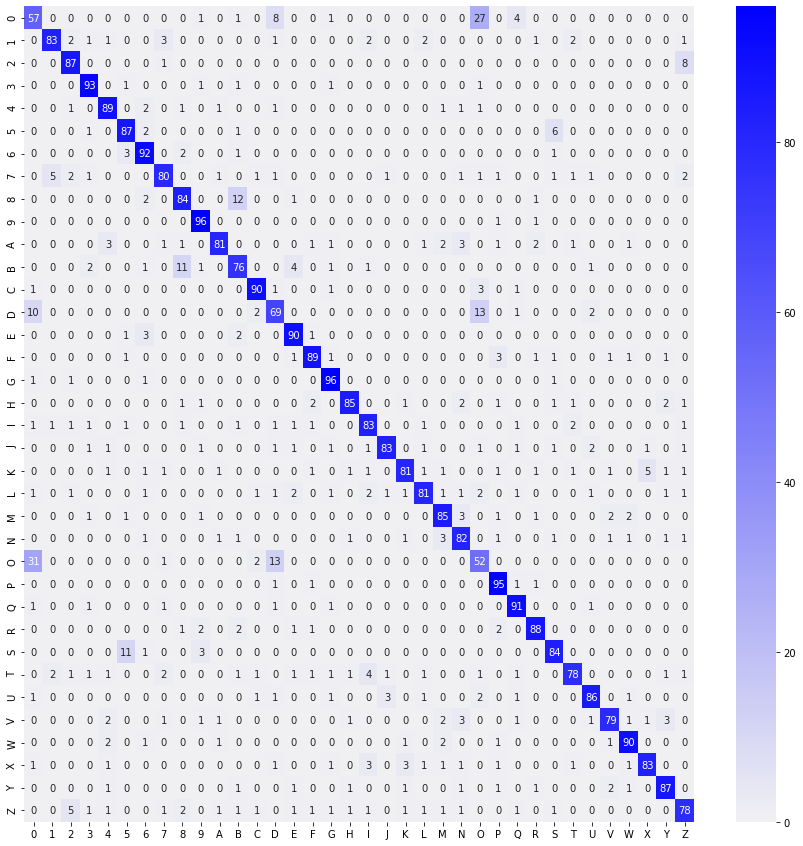

In [24]:
evaluate_base_model(base_model, valid)
get_confusion_matrix_base_model(base_model, valid)

Character Accuracy: 0.8362727272727273
Captcha Accuracy: 0.49636363636363634


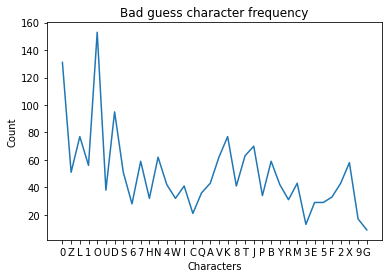

In [25]:
evaluate_base_model(base_model, test)

## **Part 4: Primary Model**

The primary model is a standard CNN with two convolutional layers and three fully-connected layers. Each convolutional layer is coupled with a max pooling layer (stride 2). Dropout is used for the FC network to help reduce overfitting. The CNN takes an entire CAPTCHA image as input, however, learns to classify each character individually. The previous segmentation module is leveraged, specifically the deep-learning implementation.

In [26]:
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [27]:
class CaptchaLargeCNN(nn.Module):
    def __init__(self):
        super(CaptchaLargeCNN, self).__init__()
        self.name = "CaptchaLargeCNN"

        self.conv1 = nn.Conv2d(1, 5, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 7)
        self.pool2 = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(2560, 1000)
        self.fc2 = nn.Linear(1000, 250)
        self.fc3 = nn.Linear(250, 36)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, img, preprocessed=False):
        if not preprocessed:
          x = getcharacterimages(img, dheight=80, dwidth=80, deeplearning=True)
        else:
          x = img

        x = x.reshape(-1, 1, 80, 80)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 2560)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)

In [28]:
def plot(title, xlabel, ylabel, data1, data1_label, data2, data2_label, epochs):
    plt.title(title)
    plt.plot(epochs, data1, label=data1_label)
    if data2 is not None:
      plt.plot(epochs, data2, label=data2_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()

In [29]:
def get_accuracy(model, data_loader):
  total = 0
  correct = 0
  char_correct = 0
  captcha_length = 5
  for imgs, labels in data_loader:
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

      for i in range(batch_size):
        output = model(imgs[i].unsqueeze(dim=0), preprocessed=True)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        num_correct = 0
        for j in range(captcha_length): 
          # print(labels[i][j])
          # print(pred[j])
          if labels[i][j] == pred[j].squeeze(0):
            num_correct += 1
            char_correct += 1
          # print(num_correct)
        if num_correct == 5:
          correct += 1
        total += 1
  return correct / total, char_correct / (5 * total)

In [30]:
def get_confusion_matrix(model, dataloader):

  matrix = np.zeros((len(dataset.character_set), len(dataset.character_set)))
  character_frequency = np.zeros(len(dataset.character_set))

  for images, labels in dataloader:

    if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    out = model(images, preprocessed=True)
    out = out.max(1, keepdim=True)[1]
    out = out.reshape(-1, 5)  # Shape back into per captcha 

    # Iterate through each sample captcha in batch
    for i in range(len(labels)):
      # Iterate through each character of captcha
      for j in range(len(labels[i])):
        guess = int(out[i][j])
        expected = int(labels[i][j])

        character_frequency[guess] = character_frequency[guess] + 1
        matrix[guess][expected] = matrix[guess][expected] + 1
  
  # Normalize to percentages
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      matrix[i][j] = (matrix[i][j] / character_frequency[i] * 100).round()
  
  plt.subplots(figsize=(15,15))
  labels = dataset.character_set
  sns.heatmap(matrix, annot=True, cmap=sns.color_palette("light:b", as_cmap=True), xticklabels=labels, yticklabels=labels)

In [31]:
def get_model_name(name, epoch, learning_rate=1e-4):
  """
  Generate a name for the model consisting of all the hyperparameter values
  """
  path="model_{0}_lr{1}_epoch{2}".format(
      name, learning_rate, epoch)
  return path

In [32]:
def train_cnn(model, x, y, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(360)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    train_loader = x
    valid_loader = y

    iters = []
    losses = []
    train_acc = []
    valid_acc = []

    epoch = 0

    for epoch in range(num_epochs):

        random.shuffle(train_loader)

        for imgs, labels in train_loader:  
            labels = labels.reshape(-1)

            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
                
            out = model(imgs, preprocessed=True) # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean up step for PyTorch

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, epoch, learning_rate=learning_rate)
        torch.save(model.state_dict(), model_path)

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss))  # compute *average* loss
        captcha_acc, char_acc = get_accuracy(model, train_loader)
        train_acc.append(captcha_acc)  # compute training accuracy
        if y != None:
            valid_acc.append(
                get_accuracy(model, valid_loader)[0]
            )  # compute validation accuracy
        if y != None:
            print(
                (
                    "Epoch {}: Character accuracy: {}, Training accuracy: {}, " + "Validation accuracy: {}"
                ).format(epoch + 1, char_acc, train_acc[epoch], valid_acc[epoch])
            )
        else:
            print(
                ("Epoch {}: Character accuracy: {}, Training accuracy: {}").format(epoch + 1, char_acc, train_acc[epoch])
            )
        epoch += 1

    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, train_acc, label="Train")
    if y != None:
        plt.plot(iters, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    if y != None:
        return losses, train_acc, valid_acc
    return losses, train_acc

In [33]:
# Preprocess segmentation on dataset to improve training times

cnn_train, cnn_valid = [], []
batch_size = 4

train, valid, test = get_data_loaders(dataset, batch_size)

for images, labels in train:
    cnn_train.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

for images, labels in valid:
    cnn_valid.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

Epoch 1: Character accuracy: 0.7631859756097561, Training accuracy: 0.3176448170731707, Validation accuracy: 0.31005338078291816
Epoch 2: Character accuracy: 0.8280106707317073, Training accuracy: 0.46389100609756095, Validation accuracy: 0.4737544483985765
Epoch 3: Character accuracy: 0.8607278963414634, Training accuracy: 0.5628810975609756, Validation accuracy: 0.5573843416370107
Epoch 4: Character accuracy: 0.8729992378048781, Training accuracy: 0.5975609756097561, Validation accuracy: 0.5876334519572953
Epoch 5: Character accuracy: 0.8820121951219512, Training accuracy: 0.6292873475609756, Validation accuracy: 0.5960854092526691
Epoch 6: Character accuracy: 0.8919969512195122, Training accuracy: 0.6578696646341463, Validation accuracy: 0.6218861209964412
Epoch 7: Character accuracy: 0.897313262195122, Training accuracy: 0.6791158536585366, Validation accuracy: 0.6481316725978647
Epoch 8: Character accuracy: 0.905640243902439, Training accuracy: 0.703125, Validation accuracy: 0.672

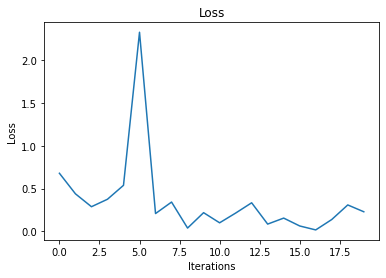

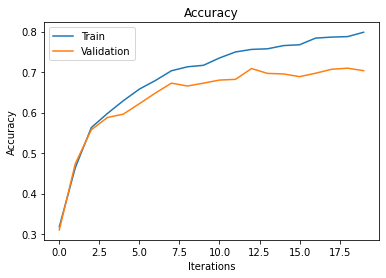

In [34]:
use_cuda = True
model = CaptchaLargeCNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()

losses, train_acc, valid_acc = train_cnn(model, cnn_train, cnn_valid, 20, 0.0001)

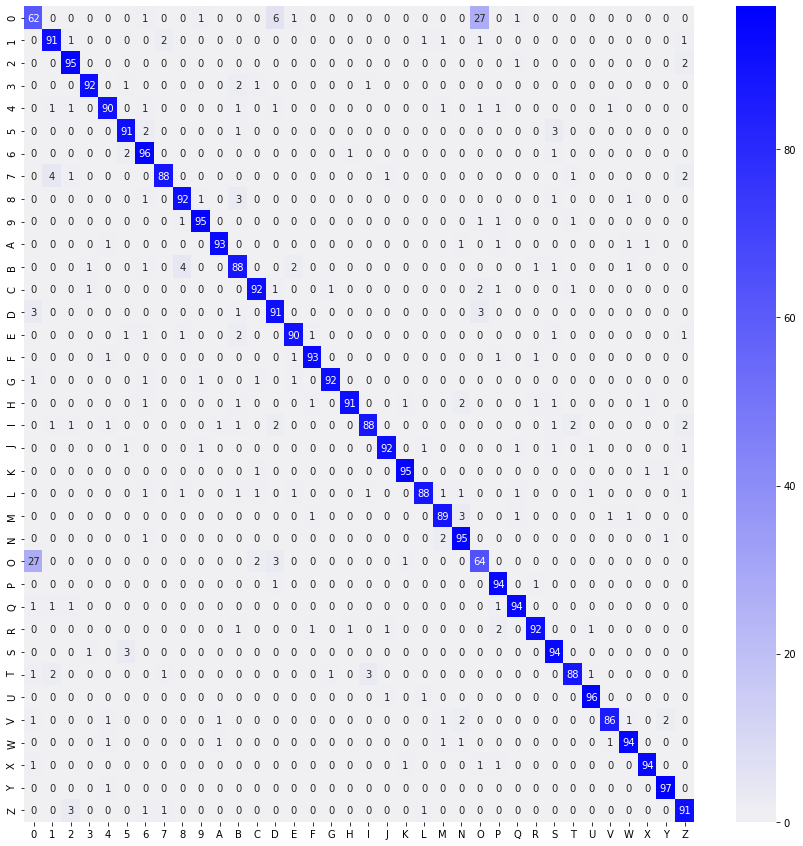

In [35]:
get_confusion_matrix(model, cnn_valid)

In [36]:
# Preprocess segmentation on dataset to improve training times

cnn_test = []
batch_size = 4

train, valid, test = get_data_loaders(dataset, batch_size)

for images, labels in test:
    cnn_test.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

model = CaptchaLargeCNN()
if use_cuda and torch.cuda.is_available():
  model.cuda()
model.load_state_dict(torch.load(get_model_name(model.name, epoch=16, learning_rate=0.0001)))
get_accuracy(model, cnn_test)

(0.7050711743772242, 0.9064946619217081)

## **Part 5: AlexNet Transfer Learning**

The pretrained AlexNet model was imported as a backup to the primary model if the CNN architecture yielded subpar results. Similar to the primary model, the AlexNet model was coupled with the character segmentation module.

In [37]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

AlexNet_train, AlexNet_valid, AlexNet_test = [], [], []

train, valid, test = get_data_loaders(dataset, 100)

for images, labels in train:
    AlexNet_train.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

for images, labels in valid:
    AlexNet_valid.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

for images, labels in test:
    AlexNet_test.append((getcharacterimages(images, dwidth=80, dheight=80, deeplearning=True), labels))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [38]:
imgs_train, labels_train = [], []
imgs_valid, labels_valid = [], []
imgs_test, labels_test = [], []

for img, label in AlexNet_train:
    img_grey = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img_grey.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_train.append(features)
    labels_train.append(label)

for img, label in AlexNet_valid:
    img = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_valid.append(features)
    labels_valid.append(label)

for img, label in AlexNet_test:
    img = img.reshape(-1, 1, 80, 80)
    label = label.reshape(-1)
    img_color = img.repeat(1,3,1,1)
    features = torch.from_numpy(alexnet.features(img_color).detach().numpy())
    imgs_test.append(features)
    labels_test.append(label)

AlexNet_train = list(zip(imgs_train, labels_train))
AlexNet_valid = list(zip(imgs_valid, labels_valid))
AlexNet_test = list(zip(imgs_test, labels_test))

In [39]:
def get_accuracy_alexnet(model, data_loader):
  total = 0
  correct = 0
  char_correct = 0
  captcha_length = 5
  for imgs, labels in data_loader:
      if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      output = model(imgs)
      pred = output.max(1, keepdim=True)[1].squeeze(1) # get the index of the max logit
      for i in range(0, len(output), captcha_length):
        num_correct = 0
        for j in range(captcha_length):
          if labels[i+j] == pred[i+j]:
            num_correct += 1
            char_correct += 1
        if num_correct == 5:
          correct += 1
        total += 1
  return correct / total, char_correct / (5 * total)

def train_alexnet(model, x, y, batch_size=128, num_epochs=20, learning_rate=0.001):
    torch.manual_seed(360)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = x
    valid_loader = y

    iters = []
    losses = []
    train_acc = []
    valid_acc = []

    epoch = 0

    for epoch in range(num_epochs):
        for img, label in train_loader:  
            if use_cuda and torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()
            out = model(img) # forward pass
            loss = criterion(out, label) # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean up step for PyTorch

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, epoch, learning_rate=learning_rate)
        torch.save(model.state_dict(), model_path)

        # save the current training information
        iters.append(epoch)
        losses.append(float(loss))  # compute *average* loss
        captcha_acc, char_acc = get_accuracy_alexnet(model, train_loader)
        train_acc.append(captcha_acc)  # compute training accuracy
        if y != None:
            captcha_acc, char_acc = get_accuracy_alexnet(model, valid_loader)  # compute validation accuracy
            valid_acc.append(captcha_acc)
        if y != None:
            print(
                (
                    "Epoch {}: Character accuracy: {}, Training accuracy: {}, " + "Validation accuracy: {}"
                ).format(epoch + 1, char_acc, train_acc[epoch], valid_acc[epoch])
            )
        else:
            print(
                ("Epoch {}: Character accuracy: {}, Training accuracy: {}").format(epoch + 1, char_acc, train_acc[epoch])
            )
        epoch += 1

        # model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        # torch.save(model.state_dict(), model_path)
    plt.title("Loss")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy")
    plt.plot(iters, train_acc, label="Train")
    if y != None:
        plt.plot(iters, valid_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    if y != None:
        return losses, train_acc, valid_acc
    return losses, train_acc

In [40]:
class AlexNetANNClassifier(nn.Module):
    def __init__(self):
        super(AlexNetANNClassifier, self).__init__()
        self.name = "AlexNetANNClassifier"
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36)

    def forward(self, img):
        x = img.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

Epoch 1: Character accuracy: 0.20136363636363636, Training accuracy: 0.0003846153846153846, Validation accuracy: 0.0
Epoch 2: Character accuracy: 0.3432727272727273, Training accuracy: 0.005192307692307692, Validation accuracy: 0.0027272727272727275
Epoch 3: Character accuracy: 0.48409090909090907, Training accuracy: 0.03221153846153846, Validation accuracy: 0.031818181818181815
Epoch 4: Character accuracy: 0.5541818181818182, Training accuracy: 0.06403846153846154, Validation accuracy: 0.06318181818181819
Epoch 5: Character accuracy: 0.5951818181818181, Training accuracy: 0.09423076923076923, Validation accuracy: 0.09909090909090909
Epoch 6: Character accuracy: 0.6288181818181818, Training accuracy: 0.12153846153846154, Validation accuracy: 0.13
Epoch 7: Character accuracy: 0.6515454545454545, Training accuracy: 0.14615384615384616, Validation accuracy: 0.15136363636363637
Epoch 8: Character accuracy: 0.6698181818181819, Training accuracy: 0.16413461538461538, Validation accuracy: 0.1

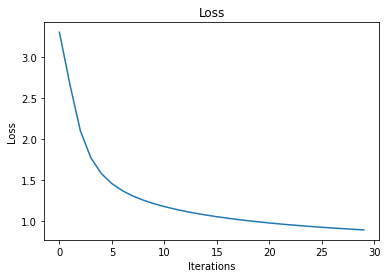

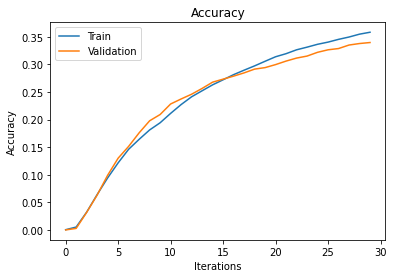

In [41]:
model = AlexNetANNClassifier()
if torch.cuda.is_available():
    model.cuda()

losses, train_acc, valid_acc = train_alexnet(model, AlexNet_train, AlexNet_valid, 32, 30, 0.0001)

In [43]:
model = AlexNetANNClassifier()
if torch.cuda.is_available():
    model.cuda()
model.load_state_dict(torch.load(get_model_name(model.name, epoch=23, learning_rate=0.0001)))

get_accuracy_alexnet(model, AlexNet_test)

(0.3259090909090909, 0.7692727272727272)

## **Part 6: End-to-End System**

The end-to-end system takes in a single CAPTCHA image and attempts to decode it. Currently, the end-to-end system performs character classification using the "best" CNN model from training as it yielded the highest accuracies without overfitting. The end-to-end system outputs its prediction of each character (5 total) and the input itself for comparison.

In [44]:
def decodeCharacter (encodedValue):
  if (encodedValue < 10):
    return str(encodedValue)
  else:
    return chr(encodedValue + 55)

In [45]:
def e2emodel (imgs):
  model = CaptchaLargeCNN()
  model.load_state_dict(torch.load(get_model_name(model.name, epoch=19, learning_rate=0.0001)))

  # Prediction
  out = model(imgs)
  pred = out.max(1, keepdim=True)[1].squeeze(1).tolist()[:5]
  CAPTCHA_prediction = list(map(decodeCharacter, pred))
  print(f"Predicted output = {CAPTCHA_prediction}")

  # Plot batch of images
  plt.imshow(imgs[0][0])

Predicted output = ['L', '4', 'Q', '6', 'Z']


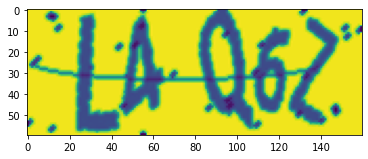

In [47]:
imgs, labels = next(iter(test))
e2emodel(imgs)